Assignment No. 1 = price prediction Linear Regression, Random Forest Regression

1) Pre process the data
2) Identify outliers
3) check the correlation
4) implement linear regression
5) implement random forest regression
6) evaluate R2, RMSE

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from haversine import haversine

In [2]:
df = pd.read_csv('uber.csv')

In [3]:
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [4]:
df.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2.000000e+05,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,2.771250e+07,11.359955,-72.527638,39.935885,-72.525292,39.923890,1.684535
std,1.601382e+07,9.901776,11.437787,7.720539,13.117408,6.794829,1.385997
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382535e+07,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000
50%,2.774550e+07,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000
75%,4.155530e+07,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [6]:
df.isnull().sum()

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [7]:
df.dropna(inplace=True)
df.isnull().sum()

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [8]:
df = df.drop(['Unnamed: 0', 'key'], axis=1)
df.pickup_datetime = pd.to_datetime(df.pickup_datetime, errors='coerce')

In [9]:
df['day_of_week']=df['pickup_datetime'].dt.dayofweek
df['hour']=df['pickup_datetime'].dt.hour
df['month']=df['pickup_datetime'].dt.month
df['day']=df['pickup_datetime'].dt.day
df=df.drop('pickup_datetime', axis=1)

In [10]:
# checking for records with negative and zero fare amount
df[df['fare_amount'] <= 0].count()

fare_amount          22
pickup_longitude     22
pickup_latitude      22
dropoff_longitude    22
dropoff_latitude     22
passenger_count      22
day_of_week          22
hour                 22
month                22
day                  22
dtype: int64

In [11]:
# removing negative, zero fare amount records
df = df[df['fare_amount'] > 0]
df[df['fare_amount'] <= 0].count()

fare_amount          0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
day_of_week          0
hour                 0
month                0
day                  0
dtype: int64

In [12]:
# checking & removing passenger counts with zero and negative
df[df['passenger_count'] <= 0].count()

fare_amount          708
pickup_longitude     708
pickup_latitude      708
dropoff_longitude    708
dropoff_latitude     708
passenger_count      708
day_of_week          708
hour                 708
month                708
day                  708
dtype: int64

In [13]:
# removing passenger count with zero, negative records:
df = df[df['passenger_count'] > 0]
df[df['passenger_count'] <= 0].count()

fare_amount          0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
day_of_week          0
hour                 0
month                0
day                  0
dtype: int64

In [14]:
# longitude: btn -180 -> 180
# latitude: btn -90 -> 90

df = df[
    (df['pickup_longitude'] >= -180) & (df['pickup_longitude'] <= 180)
    &
    (df['dropoff_longitude'] >= -180) & (df['dropoff_longitude'] <= 180)
    &
    (df['pickup_latitude'] >= -90) & (df['pickup_latitude'] <= 90)
    &
    (df['dropoff_latitude'] >= -90) & (df['dropoff_latitude'] <= 90)
    ]

In [15]:
# Now calculating the distance between pickup and drop
def calculate_distance(row):
    loc1 = (row['pickup_latitude'], row['pickup_longitude'])
    loc2 = (row['dropoff_latitude'], row['dropoff_longitude'])
    return haversine(loc1, loc2)

df['distance_km'] = df.apply(calculate_distance, axis=1)
df=df.drop('pickup_latitude', axis=1)
df=df.drop('pickup_longitude', axis=1)
df=df.drop('dropoff_latitude', axis=1)
df=df.drop('dropoff_longitude', axis=1)

In [16]:
df['distance_km'].describe()

count    199257.000000
mean         20.320761
std         376.847583
min           0.000000
25%           1.215416
50%           2.121938
75%           3.875857
max        8782.910738
Name: distance_km, dtype: float64

<Axes: xlabel='distance_km', ylabel='fare_amount'>

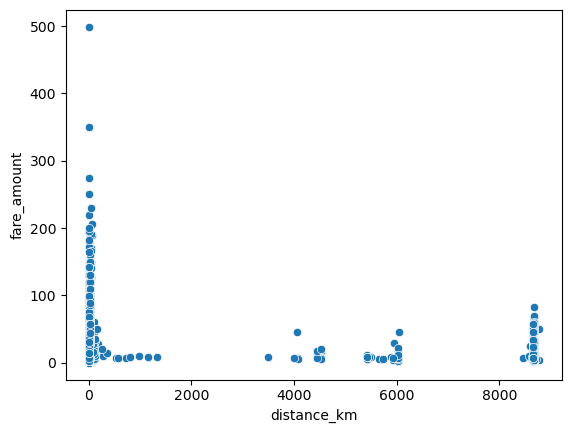

In [17]:
sb.scatterplot(x=df['distance_km'], y=df['fare_amount'])

<Axes: xlabel='distance_km'>

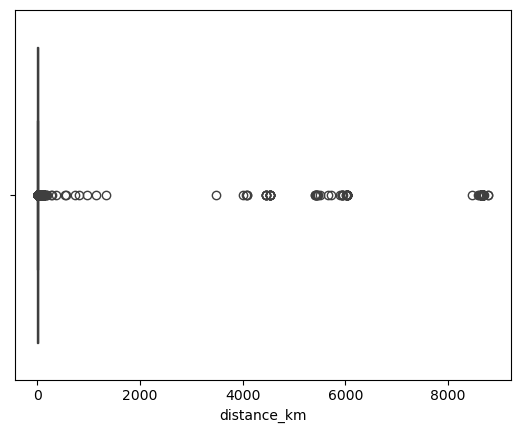

In [18]:
sb.boxplot(x=df['distance_km'])

In [19]:
# let's take the distance less than 60:
df = df[(df['distance_km'] > 0) & (df['distance_km'] < 60)]

<Axes: xlabel='distance_km', ylabel='fare_amount'>

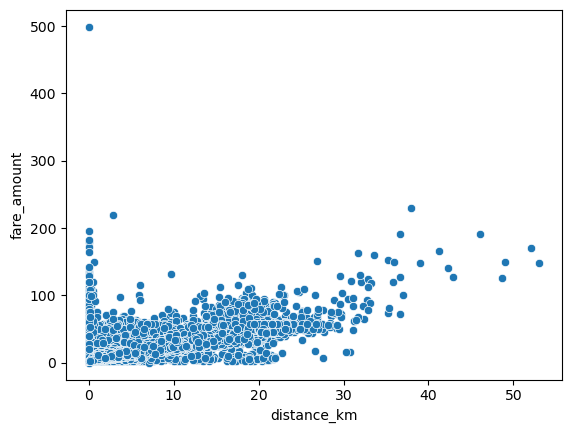

In [20]:
sb.scatterplot(x=df['distance_km'], y=df['fare_amount'])

<Axes: xlabel='fare_amount'>

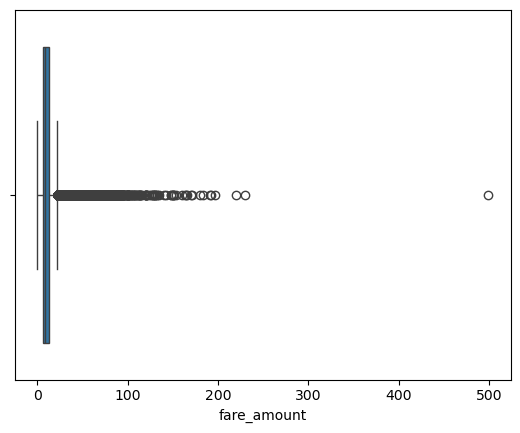

In [21]:
sb.boxplot(x=df['fare_amount'])

In [22]:
# let's take fare amount till 200:
df = df[(df['fare_amount'] > 0) & (df['fare_amount'] < 200)]

<Axes: xlabel='distance_km', ylabel='fare_amount'>

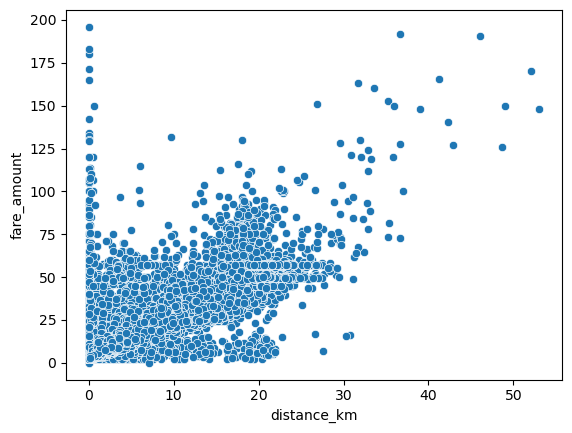

In [23]:
sb.scatterplot(x=df['distance_km'], y=df['fare_amount'])

<Axes: xlabel='passenger_count'>

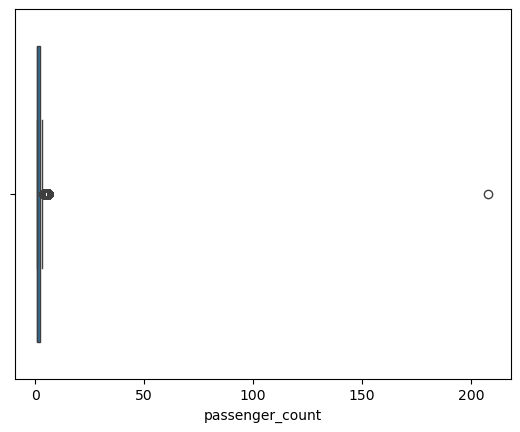

In [24]:
# Now checking for passenger count:
sb.boxplot(x=df['passenger_count'])

In [25]:
df['passenger_count'].describe()

count    193165.000000
mean          1.690995
std           1.387444
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         208.000000
Name: passenger_count, dtype: float64

Now the distance is in range (0, 60). and fare amount in range (0, 200). 
SO now all the key outliers are manually removed..
Means now if we further try to remove outliers using IQR, the ranges of distance and fare amoun will shrink further for no reason leading to less acurate models..
(so, REMOVING THE OUTLIERS OF THE COLUMN "PASSENGER COUNTS" ONLY)

In [26]:
Q1 = df['passenger_count'].quantile(0.25)
Q3 = df['passenger_count'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
    
df['passenger_count'] = np.clip(df['passenger_count'] , lower_bound , upper_bound)

<Axes: xlabel='passenger_count'>

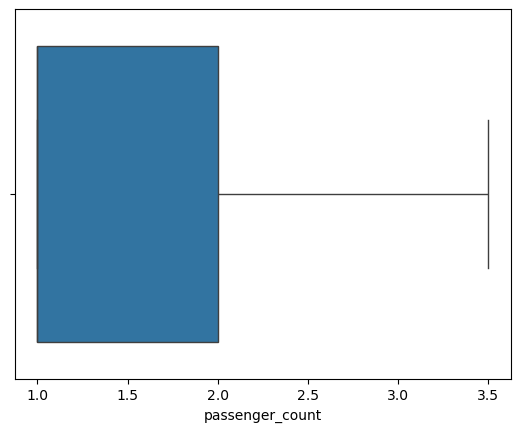

In [27]:
sb.boxplot(x=df['passenger_count'])

In [28]:
df['distance_km'].describe()

count    193165.000000
mean          3.351872
std           3.599437
min           0.000084
25%           1.279991
50%           2.180069
75%           3.937516
max          53.066174
Name: distance_km, dtype: float64

<Axes: xlabel='distance_km', ylabel='fare_amount'>

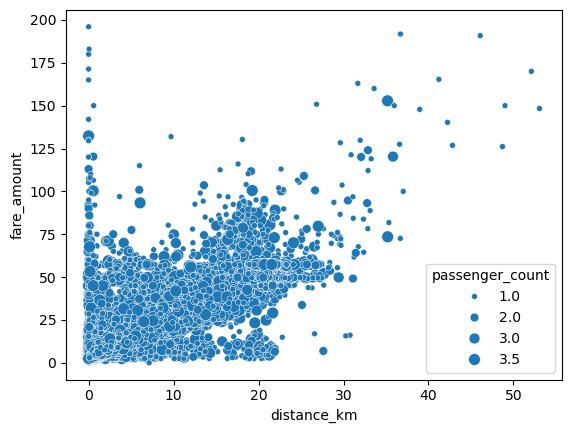

In [29]:
sb.scatterplot(x=df['distance_km'], y=df['fare_amount'], size=df['passenger_count'])

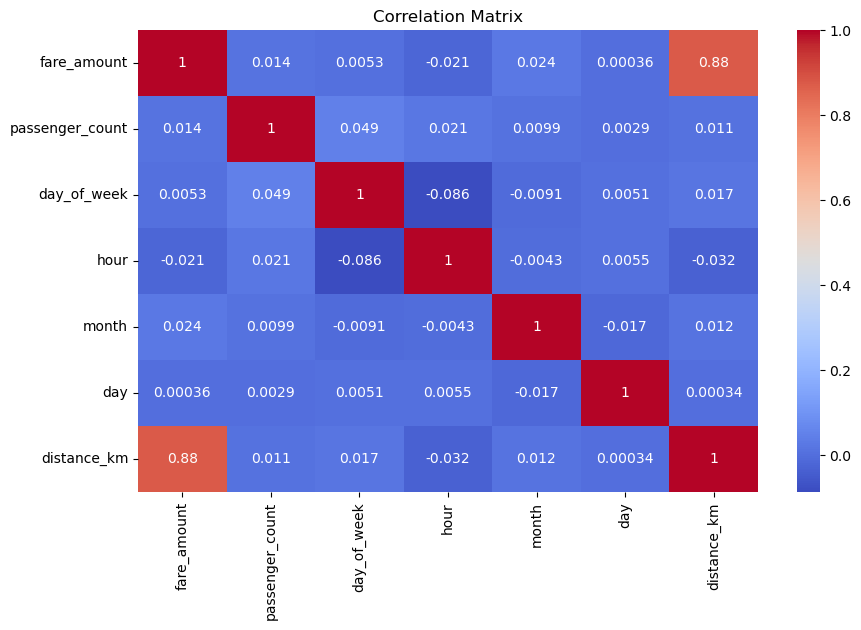

In [30]:
# Correlation Mattrix:
plt.figure(figsize=(10,6))
sb.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [31]:
X=df.drop('fare_amount', axis=1)
y=df['fare_amount']

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
lin_reg = LinearRegression()

In [35]:
lin_reg.fit(X_train, y_train)

LinearRegression()

In [36]:
y_pred = lin_reg.predict(X_test)

In [37]:
y_pred

array([5.49605711, 8.04184117, 6.17739104, ..., 5.71075715, 6.79259786,
       9.36876567])

In [38]:
random_forest = RandomForestRegressor(n_estimators=50, random_state=42)

In [39]:
random_forest.fit(X_train, y_train)

RandomForestRegressor(n_estimators=50, random_state=42)

In [40]:
y_pred2 = random_forest.predict(X_test)

In [41]:
y_pred2

array([5.438, 7.172, 6.514, ..., 4.882, 6.15 , 9.466])

Now evaluating the accuracy of these models:

In [42]:
r1 = r2_score(y_test, y_pred)
mse1 = mean_squared_error(y_test, y_pred)
rmse1 = np.sqrt(mse1)

print("The R2 score for Linear Regression is: ", r1)
print("The Mean Square error for lin reg is: ", mse1)
print("The RMSE for lin red is: ", rmse1)

The R2 score for Linear Regression is:  0.7767641115111817
The Mean Square error for lin reg is:  20.342308269086313
The RMSE for lin red is:  4.510244812544693


In [43]:
r2 = r2_score(y_test, y_pred2)
mse2 = mean_squared_error(y_test, y_pred2)
rmse2 = np.sqrt(mse2)

print("The r2 score for Random forest is: ", r2)
print("The MSE for random forest is: ", mse2)
print("The RMSE for random forest is: ", rmse2)

The r2 score for Random forest is:  0.7780302600055228
The MSE for random forest is:  20.22693083958481
The RMSE for random forest is:  4.4974360295155735
